# Lab 1

## Task 1

Выполните следующие шаги:

* Скачайте файл с предложениями (sentences.txt).
* Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
* Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
* Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
* Создайте матрицу размера n * d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
* Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
* Запишите полученные числа в файл, разделив пробелом. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-1.txt).
* Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?
* Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова. Позже мы будем подробно изучать анализ текстов, где выясним, как достичь высокого качества в задаче поиска похожих предложений.

In [35]:
import re 
from collections import Counter

import numpy as np
from scipy.spatial.distance import cosine

In [36]:
TOKENIZER = re.compile(r'[^A-Za-z]', re.I)

In [37]:
with open('sentences.txt', 'r') as f:
    lines = f.readlines()

word_lines = [[word.lower() for word in TOKENIZER.split(line) if len(word) > 0] for line in lines]
all_words = tuple(set(w for l in word_lines for w in l))
words_count = len(all_words)

In [38]:
words_count = len(all_words)
lines_count = len(lines)

In [39]:
assert words_count == 254
assert lines_count == 22

In [40]:
#data = np.zeros((lines_count, words_count), dtype=int)

In [41]:
#for i in range(lines_count):
#    line_counter = Counter(word_lines[i])
#    for j in range(words_count):
#        data[i, j] = line_counter[all_words[j]]

In [42]:
data = np.array([wlin_cnt[word] for wlin_cnt in
                 (Counter(l) for l in word_lines) for word in all_words],
                dtype=int).reshape(lines_count, words_count)

Because cosine function is defined as $ 1 - \frac{ \langle x, y \rangle }{ \|x\| \|y\| } $ i need to use smallest values. So 1 for $ cos(\alpha, \alpha) = 1 $ distance mean two vectors are equvivalent, but $ 1 - X = 0 $ inverts the result

In [43]:
cos_dist = [(i, cosine(data[0], data[i])) for i in range(1, lines_count)]
res = sorted(cos_dist, key=lambda x: x[1])[:2]

In [44]:
print 'Result:', res[0][0], ' ', res[1][0]

Result: 6   4


In [45]:
with open('submission-1.txt', 'w') as f:
    f.write('%d %d' % (res[0][0], res[1][0]))

In [46]:
!cat submission-1.txt

6 4

## Task 2

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

$$ f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2) $$


Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть $ w_0 + w_1 x + w_2 x^2 + ... + w_n x^n $) однозначно определяется любыми $ n + 1 $ различными точками, через которые он проходит. Это значит, что его коэффициенты $ w_0, ... w_n $ можно определить из следующей системы линейных уравнений:

$$ 
\begin{cases}
w_0 + w_1 x_1 + w_2 x^2_1 + ... + w_n x^n_1 = f(x_1) \\
...\\
w_0 + w_1 x_{n+1} + w_2 x^2_{n + 1} + ... + w_n x^n_{n + 1} = f(x_{n + 1})
\end{cases}
$$

где через $ x_1, ..., x_n, x_{n+1} $ обозначены точки, через которые проходит многочлен, а через $ f(x_1), ..., f(x_n), f(x_{n+1}) $ — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

* Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
* Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
* Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию? Коэффициенты данного многочлена (четыре числа: w_0, w_1, w_2, w_3) являются ответом на задачу. Округлять коэффициенты не обязательно, но при желании можете произвести округление до второго знака (т.е. до числа вида 0.42)
* Запишите полученные числа в файл, разделив пробелами. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-2.txt).

In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

In [49]:
def func(x):
    return np.sin(x / 5.0) * np.exp(x / 10.0) + 5 * np.exp(-x / 2.0)

In [50]:
tm_vec = np.arange(1, 15, 0.1)

#### First part

In [51]:
x1 = 1
x2 = 15

In [52]:
f1 = func(x1)
f2 = func(x2)

In [53]:
A = np.array([[1, x1], [1, x2]])
B = np.array([f1, f2])

In [54]:
Z = solve(A, B)

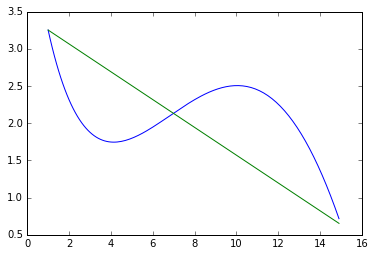

In [55]:
plt.plot(tm_vec, func(tm_vec))
plt.plot(tm_vec, (lambda x: Z[0] + x * Z[1])(tm_vec))

#### Second part

In [56]:
x1 = 1
x2 = 8
x3 = 15

In [57]:
f1 = func(x1)
f2 = func(x2)
f3 = func(x3)

In [58]:
A = np.array([
        [1, x1, x1**2],
        [1, x2, x2**2],
        [1, x3, x3**2]])
B = np.array([f1, f2, f3])

In [59]:
Z = solve(A, B)

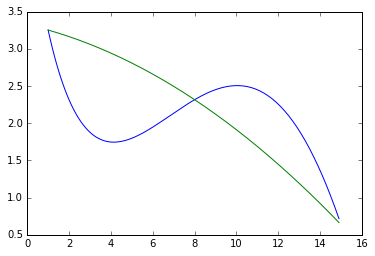

In [60]:
plt.plot(tm_vec, func(tm_vec))
plt.plot(tm_vec, (lambda x: Z[0] + (x * Z[1]) + ((x ** 2) * Z[2]))(tm_vec))

#### Third step

In [61]:
x1 = 1
x2 = 4
x3 = 10
x4 = 15

In [62]:
f1 = func(x1)
f2 = func(x2)
f3 = func(x3)
f4 = func(x4)

In [63]:
A = np.array([
        [1, x1, x1**2, x1**3],
        [1, x2, x2**2, x2**3],
        [1, x3, x3**2, x3**3],
        [1, x4, x4**2, x4**3]
    ])
B = np.array([f1, f2, f3, f4])

In [64]:
Z = solve(A, B)

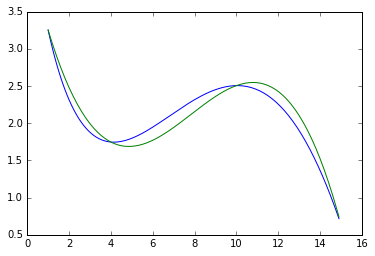

In [65]:
plt.plot(tm_vec, func(tm_vec))
plt.plot(tm_vec, (lambda x: Z[0] + (Z[1] * x) + (Z[2] * (x ** 2)) + (Z[3] * (x ** 3)))(tm_vec))

In [66]:
with open('submission-2.txt', 'w') as f:
    f.write("%f %f %f %f" % tuple(Z))

In [67]:
!cat submission-2.txt

4.362642 -1.295526 0.193337 -0.008236

#### Task 2 notes

So, in order to solve a system of linear alg equations like following

$$
\begin{cases}
3x - 9y = -42 \\
2x + 4y = 2
\end{cases}
$$
in matrix form, according to $AZ=B$ you will need to define

$$
A = \begin{bmatrix}
3 & -9 \\
2 & 4
\end{bmatrix}
$$

$$
Z = \begin{bmatrix}
x \\
y
\end{bmatrix}
$$

$$
B = \begin{bmatrix}
-42 \\
2
\end{bmatrix}
$$

than, if $ \det A \neq 0 $, you may solve this equation by using this equation $ X = A^{-1}B $. Or using numpy just by calling numpy.linalg.solve(A, B)

Next thing. Consider $ f(x) = 2x - 1 $ equation

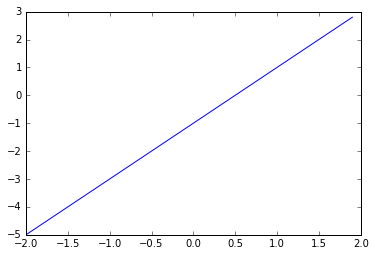

In [68]:
t1 = np.arange(-2, 2, 0.1)
plt.plot(t1, (lambda x: 2*x - 1)(t1))

Let's say that we do not know exact equation, but have only a graph above.
In order to draw this linear function (maximum pow of unknown variable is 1 [$ f(x) = kx^1 + b $]). This means that in order to find out coefficients we need at least 2 (greather by 1) linear equations like:

$$ 
\begin{cases}
w_0 + w_1 x_1 + w_2 x^2_1 + ... + w_n x^n_1 = f(x_1) \\
...\\
w_0 + w_1 x_{n+1} + w_2 x^2_{n + 1} + ... + w_n x^n_{n + 1} = f(x_{n + 1})
\end{cases}
$$

because we need at least two points to draw the line. Saying this let's select first variable $x_1 = 0.65$ and second variable $ x_2 = 0.7 $

Using graph (a picture above) we can find that for the first point $ x_1 = 0.65 $ our "unknown" function is equal to $ f(x_1) = 0.3 $ and in second point $ x_2 = 0.7 $ the function is equal to $ f(x_2) = 0.4 $

So now we can write down a system of equations which describes our "unknown" function using two points we selected.

$$ 
\begin{cases}
w_0 \times x_1^0 + w_1 \times x_1 = f(x_1) \\
w_0 \times x_2^0 + w_1 \times x_2 = f(x_2)
\end{cases}
$$

And we can substitute the rest of values:

$$ 
\begin{cases}
w_0 \times 1 + w_1 \times 0.65 = 0.3 \\
w_0 \times 1 + w_1 \times 0.7 = 0.4
\end{cases}
$$

Such as now we need just to solve $ W = A^{-1} \times B $ equation. For instance by calling numpy.linalg.solve( np.array([[1, 0.65], [1, 0.7]]), np.array([0.3, 0.4])).

What will give us result [-1, 2]

Now by substituting $w_0$ and $w_1$ the result into $w_0 \times x_1^0 + w_1 \times x_1 = f(x_1) $ equations we will have exactly our "unknown" function $-1 + 2x = f(x) \equiv f(x) = 2x - 1 $. 